<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cut-some-edges-and-evaluate-Energy-expectation" data-toc-modified-id="Cut-some-edges-and-evaluate-Energy-expectation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cut some edges and evaluate Energy expectation</a></span></li><li><span><a href="#Transfer-between-subgraphs" data-toc-modified-id="Transfer-between-subgraphs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transfer between subgraphs</a></span><ul class="toc-item"><li><span><a href="#Test-learning-$\gamma-\beta$" data-toc-modified-id="Test-learning-$\gamma-\beta$-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Test learning $\gamma \beta$</a></span></li></ul></li><li><span><a href="#Iterate-over-cut-edges-and-look-at-#-of-unique-subgraphs" data-toc-modified-id="Iterate-over-cut-edges-and-look-at-#-of-unique-subgraphs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Iterate over cut edges and look at # of unique subgraphs</a></span></li></ul></div>

In [154]:
import networkx as nx
import qtensor
from cartesian_explorer import Explorer
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Cut some edges and evaluate Energy expectation

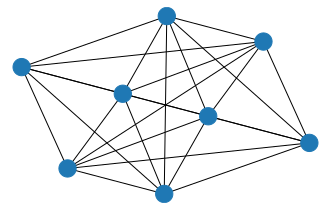

In [851]:
G = nx.random_regular_graph(6, 8, seed=990)
nx.draw_kamada_kawai(G)

In [269]:
edges_cut = [[2, 1], [7, 6], [0, 3], [5, 4], [5, 7], [0, 2], [3, 6], [4, 1],
           [3, 7], [1, 5], [2, 6], [0, 4], [0, 7], [1, 6], [2, 4], [3, 5]]


G_cut = G.copy()
for edge in edges_cut[:4]:
    G_cut.remove_edge(*edge)

In [270]:
gb1 = [1.9445362519332081], [0.5836305353850703]
e1 = qtensor.QAOA_energy(G, *gb1)
e1

array([13.73587992])

In [271]:
e2 = qtensor.QAOA_energy(G_cut, *gb1)
e2

array([11.82450875])

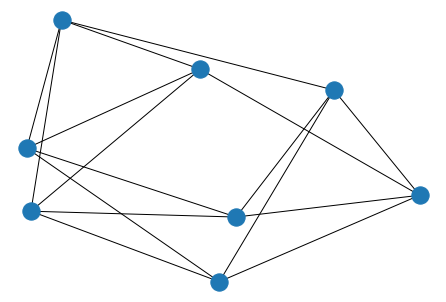

In [258]:
nx.draw_kamada_kawai(G_cut)

In [259]:
set(dict(G_cut.degree).values())

{4}

In [260]:
subgraphs = [qtensor.utils.get_edge_subgraph(G_cut, e, dist=1) for e in G_cut.edges]

In [261]:
len(subgraphs)

16

In [272]:
qtensor.tools.lightcone_orbits.graph_cert(G)

b'\x00\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x00\x00\x00\xde\x00\x00\x00\x00\x00\x00\x00\xed\x00\x00\x00\x00\x00\x00\x00\xf3\x00\x00\x00\x00\x00\x00\x00\xf3\x00\x00\x00\x00\x00\x00\x00\xed\x00\x00\x00\x00\x00\x00\x00\xde'

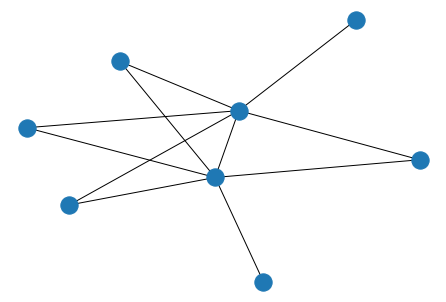

In [247]:
# subgraphs of the original
for g in subgraphs:
    nx.draw_kamada_kawai(g)
    plt.show()
    break

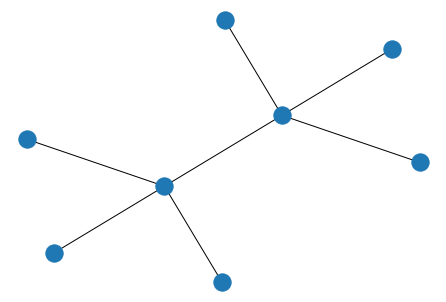

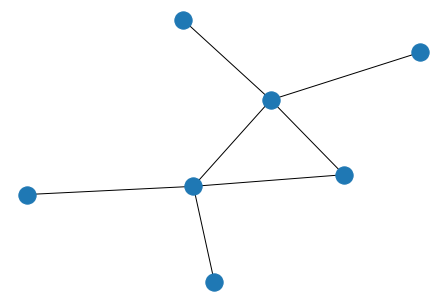

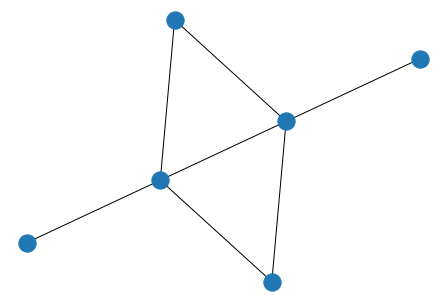

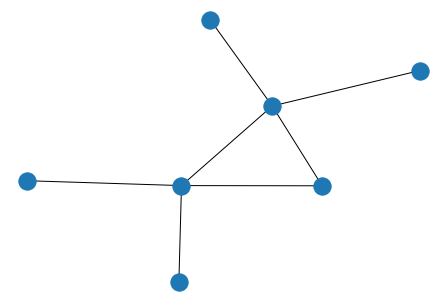

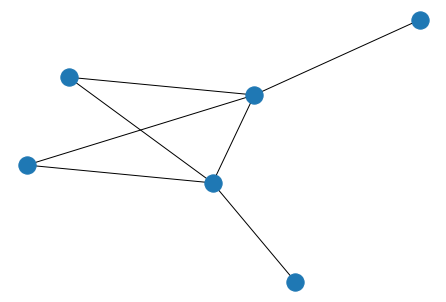

In [268]:
# subgraphs of 4-regular cut graph
for g in subgraphs[:5]:
    nx.draw_kamada_kawai(g)
    plt.show()

In [381]:
# subgraphs of 5-regular cut graph
certs = []
for e in G_cut.edges:
    subg = qtensor.utils.get_edge_subgraph(G_cut, e, dist=1) 
    g = qtensor.tools.lightcone_orbits.relabel_edge_first(subg, e)
    certs.append(qtensor.tools.lightcone_orbits.graph_cert(g))
        

## Transfer between subgraphs

matrix_ij = train on i, evaluate on j

In [639]:
# define graphs that give our subragps
parent_graphs = [G]

for cut_ix in [4, 8, 12, 16]:
    G_cut = G.copy()
    for edge in edges_cut[:cut_ix]:
        G_cut.remove_edge(*edge)
    parent_graphs.append(G_cut)

In [640]:
def get_subgraphs_and_sigs(G):
    certs, subgs = [], []
    for e in G.edges:
        subg = qtensor.utils.get_edge_subgraph(G, e, dist=1) 
        g = qtensor.tools.lightcone_orbits.relabel_edge_first(subg, e)
        subgs.append(g)
        certs.append(qtensor.tools.lightcone_orbits.graph_cert(g))
    print('cert len set', len(set(certs)))
    return subgs, certs


In [641]:
all_subs, all_sigs = zip(*[get_subgraphs_and_sigs(g) for g in parent_graphs])

cert len set 1
cert len set 2
cert len set 3
cert len set 1
cert len set 1


In [642]:
# flatten the array
all_subs = sum(all_subs, [])
all_sigs = sum(all_sigs, [])
len(set(all_sigs))

8

In [643]:
uniq_subg = {sig:sub for sig, sub in zip(all_sigs, all_subs)}

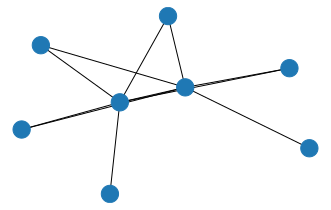

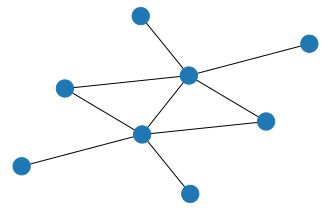

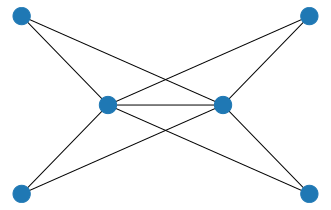

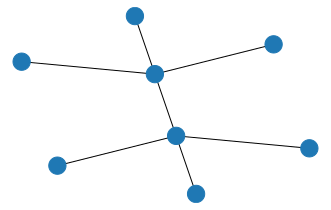

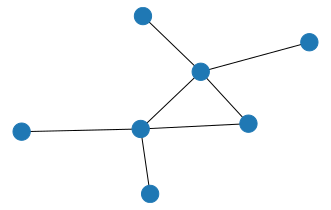

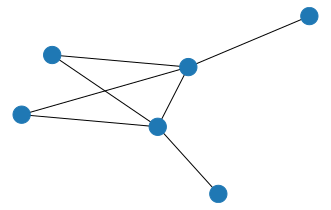

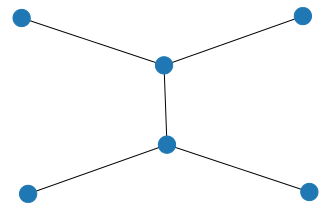

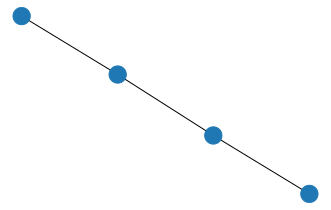

In [644]:
for g in uniq_subg.values():
    nx.draw_kamada_kawai(g)
    plt.show()

In [645]:
from qtensor import parameter_optimization as popt
import torch


In [835]:
def get_qaoa_params(graph, edge, gamma=[0.5], beta=[0.5], steps=30):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]


In [833]:
def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

### Test learning $\gamma \beta$

In [834]:
gamma, beta = [0.5], [0.5]
test_g = list(uniq_subg.values())[0]
loss_history, params_history = popt.qaoa_maxcut_torch(test_g, gamma, beta,
                                                      ordering_algo='greedy',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.RMSprop,
                                                      opt_kwargs=dict(lr=0.002),
                                                      steps=30)

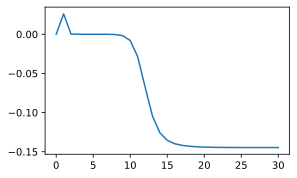

In [822]:
plt.plot(loss_history)

In [823]:
best_ix = np.argmin(loss_history)
best_params = params_history[best_ix]

In [824]:
best_params

[array([0.44435045], dtype=float32), array([0.5829056], dtype=float32)]

In [825]:
get_edge_contribution(test_g, (0,1), *best_params)

-0.14465378602660262

In [826]:
get_edge_contribution(test_g, (0,1), *gb1)

-0.14465666829437954

In [840]:

def transferrability_matrix(graphs, multistart=5):
    matrix = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta)
            print('contribution loss', loss, 'params', params)
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                similarity = trloss*loss/np.sqrt(trloss**2 + loss**2)
                matrix[i,j] += similarity
                if i==j:
                    print(loss, trloss, 'sim', similarity)
                    #assert np.allclose(loss,trloss)
    return matrix

In [845]:
mat = transferrability_matrix(uniq_subg.values(), multistart=10)

contribution loss 0.0011156693 params [array([0.68403834], dtype=float32), array([0.5078821], dtype=float32)]
0.0011156693 0.001115701785124256 sim 0.0007889087996708759


contribution loss -0.14465848 params [array([0.55544], dtype=float32), array([0.41663155], dtype=float32)]
-0.14465848 -0.14465837874191834 sim 0.10228895499017115


contribution loss -0.14285707 params [array([1.0483629], dtype=float32), array([0.9103355], dtype=float32)]
-0.14285707 -0.14285704875512711 sim 0.10101519710121966


contribution loss -0.14465849 params [array([0.9445479], dtype=float32), array([0.5833608], dtype=float32)]
-0.14465849 -0.14465837392719783 sim 0.10228895855625872


contribution loss -0.14163285 params [array([-0.04678188], dtype=float32), array([0.09277139], dtype=float32)]
-0.14163285 -0.14163282895859464 sim 0.10014954298054157


contribution loss 0.000743934 params [array([0.7755274], dtype=float32), array([0.41287956], dtype=float32)]
0.000743934 0.0007439451186191581 sim 0.0005260447112211825


contribution loss -0.14465849 params [array([0.05543964], dtype=float32), array([0.41663197], dtype=float32)]
-0.14465849 -0.1446583787534719 sim 0.10228896026260628


contribution loss -8.4293696e-08 params [array([0.7537702], dtype=float32), array([0.9694734], dtype=float32)]
-8.4293696e-08 4.84685205253531e-08 sim -4.2017742288606694e-08


contribution loss -0.14465873 params [array([0.44454715], dtype=float32), array([0.08334317], dtype=float32)]
-0.14465873 -0.14465836478056454 sim 0.10228903961591392


contribution loss -0.14465836 params [array([1.055475], dtype=float32), array([0.41668049], dtype=float32)]
-0.14465836 -0.1446583141785667 sim 0.10228889001674481


contribution loss -0.20301534 params [array([0.06720237], dtype=float32), array([0.40111035], dtype=float32)]
-0.20301534 -0.20301522419997817 sim 0.14355348348992245


contribution loss -0.20301491 params [array([0.932784], dtype=float32), array([0.09897044], dtype=float32)]
-0.20301491 -0.20301489959603058 sim 0.14355321594278841


contribution loss -0.20114817 params [array([0.9346501], dtype=float32), array([0.6078635], dtype=float32)]
-0.20114817 -0.2011481991286161 sim 0.1422332443574105


contribution loss -0.20301107 params [array([0.5671049], dtype=float32), array([0.09927318], dtype=float32)]
-0.20301107 -0.20301102143377414 sim 0.1435504855695065


contribution loss -0.20290689 params [array([0.43454984], dtype=float32), array([0.90058225], dtype=float32)]
-0.20290689 -0.20290685451473844 sim 0.14347682592485206


contribution loss -0.00052418036 params [array([0.712106], dtype=float32), array([0.51401], dtype=float32)]
-0.00052418036 -0.0005241491785868929 sim 0.00037064046205431017


contribution loss -0.20301534 params [array([0.9327889], dtype=float32), array([0.5988592], dtype=float32)]
-0.20301534 -0.2030152614811166 sim 0.14355349667080508


contribution loss -0.20301528 params [array([0.06720959], dtype=float32), array([0.90115166], dtype=float32)]
-0.20301528 -0.20301526480208681 sim 0.1435534767715292


contribution loss 8.3161e-06 params [array([0.23962201], dtype=float32), array([0.71245974], dtype=float32)]
8.3161e-06 8.319240945188078e-06 sim 5.881480993668309e-06


contribution loss -0.2030153 params [array([0.43277317], dtype=float32), array([0.9011569], dtype=float32)]
-0.2030153 -0.20301525480632981 sim 0.1435534785058495


contribution loss -0.1491468 params [array([0.4438587], dtype=float32), array([0.41809663], dtype=float32)]
-0.1491468 -0.1491466570466899 sim 0.10546266145930433


contribution loss -0.14922515 params [array([0.44256416], dtype=float32), array([0.4197707], dtype=float32)]
-0.14922515 -0.1492250370819949 sim 0.10551807400273808


contribution loss -1.0536712e-08 params [array([0.2500032], dtype=float32), array([0.8483168], dtype=float32)]
-1.0536712e-08 1.0670947549385546e-09 sim -1.0616642074226286e-09


contribution loss -0.1047941 params [array([0.03132567], dtype=float32), array([0.36682457], dtype=float32)]
-0.1047941 -0.10479397727054869 sim 0.07410057532106189


contribution loss -0.14850931 params [array([0.55962276], dtype=float32), array([0.57446265], dtype=float32)]
-0.14850931 -0.148509387484671 sim 0.10501196710418546


contribution loss -0.14922497 params [array([0.94261265], dtype=float32), array([0.08030597], dtype=float32)]
-0.14922497 -0.1492248445445533 sim 0.10551794271019437


contribution loss -0.14922471 params [array([1.0575368], dtype=float32), array([0.4198918], dtype=float32)]
-0.14922471 -0.14922469684040796 sim 0.10551780092686595


contribution loss -0.13661602 params [array([0.9556201], dtype=float32), array([0.10585187], dtype=float32)]
-0.13661602 -0.13661597548036275 sim 0.09660209891375561


contribution loss -0.14922513 params [array([0.942552], dtype=float32), array([0.58021754], dtype=float32)]
-0.14922513 -0.14922504239093598 sim 0.10551807061138319


contribution loss -0.14922325 params [array([0.5572821], dtype=float32), array([0.58048785], dtype=float32)]
-0.14922325 -0.14922331197251393 sim 0.10551679500322657


contribution loss -0.32473993 params [array([1.0827161], dtype=float32), array([0.87499994], dtype=float32)]
-0.32473993 -0.3247398710812139 sim 0.22962578685968524


contribution loss -0.32475948 params [array([0.91665107], dtype=float32), array([0.12499999], dtype=float32)]
-0.32475948 -0.32475942501634275 sim 0.22963961230290564


contribution loss -0.32475942 params [array([0.08333175], dtype=float32), array([0.37502775], dtype=float32)]
-0.32475942 -0.3247594176218814 sim 0.22963958861514722


contribution loss -0.3247591 params [array([0.5833333], dtype=float32), array([0.8749039], dtype=float32)]
-0.3247591 -0.3247592007670933 sim 0.22963939604155928


contribution loss -0.32475942 params [array([0.41665995], dtype=float32), array([0.625], dtype=float32)]
-0.32475942 -0.32475943517808165 sim 0.2296395948222013


contribution loss -0.32475916 params [array([0.58341867], dtype=float32), array([0.37502128], dtype=float32)]
-0.32475916 -0.32475905251352877 sim 0.22963936469943347


contribution loss -0.32475862 params [array([0.41672823], dtype=float32), array([0.12484602], dtype=float32)]
-0.32475862 -0.32475863512829045 sim 0.22963902747065745


contribution loss -0.32475948 params [array([0.41667503], dtype=float32), array([0.12500282], dtype=float32)]
-0.32475948 -0.32475943369926863 sim 0.22963961537278427


contribution loss -0.30455685 params [array([0.08875896], dtype=float32), array([0.40220985], dtype=float32)]
-0.30455685 -0.3045570046395183 sim 0.21535426736963154


contribution loss 1.4474126e-06 params [array([0.25439835], dtype=float32), array([0.2554657], dtype=float32)]
1.4474126e-06 1.4474013930445194e-06 sim 1.0234713075350873e-06


contribution loss -0.2623333 params [array([0.5821722], dtype=float32), array([-0.10671954], dtype=float32)]
-0.2623333 -0.2623332940508837 sim 0.1854976545623113


contribution loss -0.26303568 params [array([0.42209056], dtype=float32), array([0.6094474], dtype=float32)]
-0.26303568 -0.26303585847645267 sim 0.18599437782847728


contribution loss 2.1073424e-07 params [array([0.7489081], dtype=float32), array([0.5695674], dtype=float32)]
2.1073424e-07 2.480711345576599e-07 sim 1.606070237159926e-07


contribution loss -0.2629792 params [array([0.5782509], dtype=float32), array([-0.10704676], dtype=float32)]
-0.2629792 -0.26297919377084006 sim 0.18595437676022908


contribution loss -0.26288274 params [array([0.08009221], dtype=float32), array([0.39185014], dtype=float32)]
-0.26288274 -0.2628825348443221 sim 0.1858860953318282


contribution loss -0.26305026 params [array([0.07802773], dtype=float32), array([0.39129648], dtype=float32)]
-0.26305026 -0.26305021253793615 sim 0.1860046052078423


contribution loss -0.26069516 params [array([0.920958], dtype=float32), array([1.0991503], dtype=float32)]
-0.26069516 -0.26069513085820223 sim 0.18433930495566833


contribution loss -0.2630495 params [array([0.9218417], dtype=float32), array([0.10868277], dtype=float32)]
-0.2630495 -0.263049538092239 sim 0.18600410333747763


contribution loss -0.26305035 params [array([0.57803816], dtype=float32), array([0.39131576], dtype=float32)]
-0.26305035 -0.26305019924772866 sim 0.1860046321191607


contribution loss -0.26277608 params [array([0.57835203], dtype=float32), array([0.39455733], dtype=float32)]
-0.26277608 -0.2627759856164303 sim 0.18581071359837062


contribution loss -0.036059156 params [array([0.8314063], dtype=float32), array([1.0315032], dtype=float32)]
-0.036059156 -0.03605922015761745 sim 0.02549769643586712


contribution loss -0.21669926 params [array([0.92738193], dtype=float32), array([0.5950259], dtype=float32)]
-0.21669926 -0.2166993384656016 sim 0.15322954307952663


contribution loss 8.298714e-05 params [array([0.2425393], dtype=float32), array([0.57242286], dtype=float32)]
8.298714e-05 8.301246760977071e-05 sim 5.868972289915293e-05


contribution loss -0.2166994 params [array([0.57258165], dtype=float32), array([0.9049678], dtype=float32)]
-0.2166994 -0.21669948857155313 sim 0.1532296488335552


contribution loss -4.2146848e-08 params [array([0.74916303], dtype=float32), array([0.50694937], dtype=float32)]
-4.2146848e-08 1.2686953532762973e-08 sim -1.2148488971239161e-08


contribution loss -0.21669915 params [array([0.07263882], dtype=float32), array([0.40500775], dtype=float32)]
-0.21669915 -0.21669919207815744 sim 0.15322945444526315


contribution loss -0.21660669 params [array([0.5708191], dtype=float32), array([0.40439776], dtype=float32)]
-0.21660669 -0.21660678525904334 sim 0.15316409355166624


contribution loss -0.21669936 params [array([0.07250179], dtype=float32), array([0.4050096], dtype=float32)]
-0.21669936 -0.2166994061726259 sim 0.1532296038960727


contribution loss -0.21669945 params [array([0.42742434], dtype=float32), array([0.59503216], dtype=float32)]
-0.21669945 -0.21669950494270143 sim 0.15322967042670305


contribution loss -0.21669962 params [array([0.07253123], dtype=float32), array([0.9049485], dtype=float32)]
-0.21669962 -0.21669956118872416 sim 0.15322974826459176


contribution loss -0.3847987 params [array([0.09795115], dtype=float32), array([0.37682566], dtype=float32)]
-0.3847987 -0.3847988108689591 sim 0.2720938113319246


contribution loss -0.3806587 params [array([0.5979566], dtype=float32), array([0.63682425], dtype=float32)]
-0.3806587 -0.38065892934469664 sim 0.2691664242803987


contribution loss 8.636245e-17 params [array([0.25], dtype=float32), array([0.5662688], dtype=float32)]
8.636245e-17 1.8237229916154315e-32 sim 1.8237229916154315e-32


contribution loss -0.38490003 params [array([0.09799334], dtype=float32), array([0.87499994], dtype=float32)]
-0.38490003 -0.3849000390212289 sim 0.27216542570962493


contribution loss -0.3830815 params [array([0.40204337], dtype=float32), array([0.36726156], dtype=float32)]
-0.3830815 -0.38308164579148446 sim 0.27087957644376776


contribution loss -0.3698427 params [array([0.6011727], dtype=float32), array([0.14699274], dtype=float32)]
-0.3698427 -0.3698428180842553 sim 0.2615183257590262


contribution loss -0.38487247 params [array([0.9022457], dtype=float32), array([0.12592173], dtype=float32)]
-0.38487247 -0.3848724148191911 sim 0.27214591262061216


contribution loss -0.38489994 params [array([0.90198517], dtype=float32), array([0.625], dtype=float32)]
-0.38489994 -0.3848999460501016 sim 0.27216536122923135


contribution loss -0.38473746 params [array([0.59941983], dtype=float32), array([0.12646446], dtype=float32)]
-0.38473746 -0.3847375634101323 sim 0.2720505041417692







































































contribution loss -0.38489866 params [array([0.901861], dtype=float32), array([0.625], dtype=float32)]
-0.38489866 -0.3848985850276254 sim 0.2721644269564945


contribution loss -0.4991933 params [array([0.62952083], dtype=float32), array([0.3750001], dtype=float32)]

-0.4991933 -0.49919329128470774 sim 0.3529829682678876


contribution loss -0.5 params [array([0.62500226], dtype=float32), array([0.87499994], dtype=float32)]
-0.5 -0.49999993134025067 sim 0.3535533663183841



contribution loss -0.49998176 params [array([0.3756797], dtype=float32), array([0.625], dtype=float32)]
-0.49998176 -0.4999816928555627 sim 0.35354046957246127


contribution loss -0.49997512 params [array([0.37421018], dtype=float32), array([0.62499994], dtype=float32)]

-0.49997512 -0.4999753044226892 sim 0.3535358612335372


contribution loss -0.49978533 params [array([0.6271727], dtype=float32), array([0.8758446], dtype=float32)]
-0.49978533 -0.4997854278824169 sim 0.3534016319561148



contribution loss -0.4963102 params [array([0.61532664], dtype=float32), array([0.37501943], dtype=float32)]
-0.4963102 -0.4963103169514035 sim 0.35094435084939984


contribution loss -0.49999362 params [array([0.6246076], dtype=float32), array([0.8749118], dtype=float32)]

-0.49999362 -0.4999935462467995 sim 0.35354885399054925


contribution loss -0.49998772 params [array([0.12499999], dtype=float32), array([0.874444], dtype=float32)]
-0.49998772 -0.49998772773977473 sim 0.35354471056866427



contribution loss -0.49526176 params [array([0.614036], dtype=float32), array([0.375], dtype=float32)]
-0.49526176 -0.4952617821723876 sim 0.350202956290477


contribution loss -0.4999601 params [array([0.12600422], dtype=float32), array([0.87499994], dtype=float32)]

-0.4999601 -0.49996011983298466 sim 0.3535251821674687


In [846]:
mat

array([[ 0.71392446,  0.3153868 ,  0.25200699,  0.86813773,  0.84499355,
         0.81634837,  0.37221   ,  0.89221202],
       [ 0.01608198,  1.14740423,  0.87905921,  0.33425446,  0.27315984,
         0.20210946,  1.37429621,  0.35173199],
       [-0.04528703,  1.01373026,  0.90876598,  0.08353965,  0.05555649,
         0.02537219,  1.11680319,  0.08214242],
       [ 0.63040997, -0.61868751, -1.13961555,  2.05245728,  1.7986222 ,
         1.45373935, -0.25901513,  2.32521983],
       [ 0.89500012, -0.43227726, -0.75724242,  1.81569423,  1.67149602,
         1.47704668, -0.2145116 ,  1.98646794],
       [ 0.78360841,  0.06375285, -0.12409088,  1.25083623,  1.18469768,
         1.09809814,  0.21468841,  1.34131622],
       [-0.86062364,  1.25492017, -0.06783005,  0.25977316, -0.07173814,
        -0.42312756,  2.43434977,  0.31211796],
       [ 0.02284183, -1.54909669, -2.76112253,  2.25899998,  1.77747513,
         1.23123185, -1.74304959,  3.52878035]])

In [847]:
from IPython.display import set_matplotlib_formats
import matplotlib
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

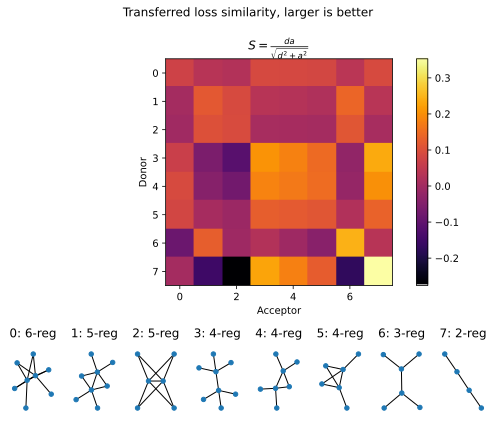

In [849]:
from matplotlib import pyplot
from matplotlib import gridspec
graphs = uniq_subg.values()

fig = pyplot.figure(figsize=(7, 6))

gs0 = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
gs01 = gridspec.GridSpecFromSubplotSpec(1, len(graphs), subplot_spec=gs0[1])

ax_mat = fig.add_subplot(gs0[0])
plt.sca(ax_mat)

if False:
    f = plt.pcolormesh(mat, cmap='inferno')
    plt.yticks(np.arange(6)+0.5, labels=np.arange(6))
    plt.xticks(np.arange(6)+0.5, labels=np.arange(6))
else:
    f = plt.imshow(mat/10, cmap='inferno')
    
plt.colorbar(f, shrink=1)
plt.title(r'$S = \frac{da}{\sqrt{d^2 + a^2}}$')
plt.suptitle('Transferred loss similarity, larger is better')
plt.ylabel('Donor')
plt.xlabel('Acceptor')

for i, g in enumerate(graphs):
    ax00 = fig.add_subplot(gs01[i])
    plt.sca(ax00)
    reg = g.degree[0]
    plt.title(f'{i}: {reg}-reg')
    plt.margins(0.2, 0.2)
    nx.draw_kamada_kawai(g, node_size=20)
    
plt.tight_layout()

In [730]:
orbits1, maxnodes = qtensor.tools.lightcone_orbits.get_edge_orbits_lightcones(G, p=1)
print('Unique subgraphs for G:', len(orbits1))

Unique subgraphs for G: 1


In [226]:
orbits2, maxnodes = qtensor.tools.lightcone_orbits.get_edge_orbits_lightcones(G_cut, p=1)
print('Unique subgraphs for G:', len(orbits2), 'maxnodes', maxnodes)

Unique subgraphs for G: 5 maxnodes 8


## Iterate over cut edges and look at # of unique subgraphs

In [241]:
G_cut = G.copy()
orbits, maxnodes = qtensor.tools.lightcone_orbits.get_edge_orbits_lightcones(G_cut, p=1)
uniques = [len(orbits)]
for e in edges_cut:
    G_cut.remove_edges_from([e])
    orbits, maxnodes = qtensor.tools.lightcone_orbits.get_edge_orbits_lightcones(G_cut, p=1)
    n_uniq = len(orbits)
    uniques.append(n_uniq)
    

In [242]:
uniques

[1, 3, 4, 5, 2, 3, 4, 5, 3, 5, 4, 4, 1, 2, 3, 3, 1]

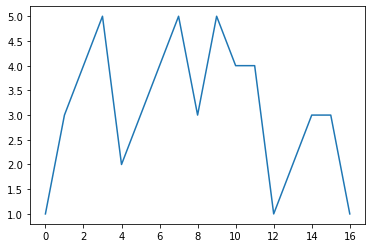

In [243]:
plt.plot(uniques)

In [106]:
ex = Explorer()

In [114]:
import numpy as np
import random

In [115]:
def get_edges_to_trim(G):
    n_edges = G.number_of_nodes()//2
    i=0
    while i<1000:
        draw = random.sample(G.edges, k=n_edges)
        if len(set(sum(draw, tuple()))) == G.number_of_nodes():
               break
    
    return draw
    

In [116]:
get_edges_to_trim(G)

[(5, 0), (2, 1), (3, 6), (4, 7)]

In [143]:
@ex.provider
def transferred_cost(graph, cut_ix):
    #edges_cut = [(2,1), (7,6), (0,3), (5,4), (5,7)]
    G = graph
    edges_cut = get_edges_to_trim(G)
    print('ecut', edges_cut)
    G_cut = G.copy()
    assert len(set(dict(G_cut.degree).values())) == 1
    for edge in edges_cut[:cut_ix]:
        G_cut.remove_edge(*edge)
        
    gb1 = [1.9445362519332081], [0.5836305353850703]
    e1 = qtensor.QAOA_energy(G_cut, *gb1)
    return e1

@ex.provider
def graph(n=8, d=6, seed=10):
    return nx.random_regular_graph(d, n, seed=seed)


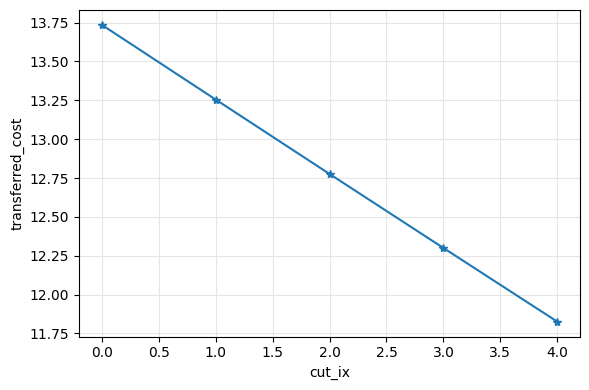

In [145]:
fig = ex.plot_variables(('transferred_cost'),
                        distribution_var=('seed'),
                        plot_kwargs=dict(marker='*'),
                        cut_ix=range(5),
                        seed=range(10)
                 )